In [1]:
# --- 1. Imports et Configuration ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix
import mlflow


c:\Users\pc\Documents\churn_prediction_system\.venv\Lib\site-packages\mlflow\protos\service_pb2.py:11: UserWarning: google.protobuf.service module is deprecated. RPC implementations should provide code generator plugins which generate code specific to the RPC implementation. service.py will be removed in Jan 2025
  from google.protobuf import service as _service
c:\Users\pc\Documents\churn_prediction_system\.venv\Lib\site-packages\mlflow\utils\requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [12]:
mlflow.set_tracking_uri("file:../mlruns")

In [13]:

# Ajouter le répertoire parent au chemin pour importer nos modules
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import load_config
from src.data_preprocessing import load_raw_data, preprocess_and_split_data

print("Setup terminé.")

Setup terminé.


In [14]:

# --- 2. Charger les Données de Test ---
#Nous avons besoin des mêmes données de test sur lesquelles le modèle a été évalué
config = load_config(config_path="../params.yml")
raw_df = pd.read_csv(config['data']['raw_data_path'])

# Ré-exécuter le pipeline de prétraitement pour obtenir X_test_transformed et y_test
# C'est la manière la plus fiable de s'assurer que nous utilisons les mêmes données
_, X_test_transformed, _, y_test, _ = preprocess_and_split_data(raw_df.copy(), config)

print(f"Données de test chargées. Shape: {X_test_transformed.shape}")


Configuration loaded successfully from ../params.yml
Création de nouvelles caractéristiques (Feature Engineering)...
Nouvelles caractéristiques créées.
Data split into training (5625 samples) and test (1407 samples) sets.
Fitting preprocessing pipeline on training data...
Preprocessing pipeline fitted.
Data transformed successfully.
Object saved successfully to data/preprocessor.joblib
Données de test chargées. Shape: (1407, 38)


In [15]:
# --- 3. Charger le Meilleur Modèle XGBoost depuis MLflow ---

# REMPLACE CET ID PAR CELUI QUE TU AS COPIÉ
RUN_ID = "bd74a95b12224416a60f1b3a115fa036" # <--- METS TON RUN ID ICI !

# Construire le chemin vers l'artefact du modèle
# Le nom "model_XGBoost" est celui que nous avons donné dans `artifact_path` lors du `mlflow.sklearn.log_model`
model_uri = f"runs:/{RUN_ID}/model_XGBoost"

# Charger le pipeline complet (SMOTE + XGBoost)
try:
    best_xgboost_pipeline = mlflow.sklearn.load_model(model_uri)
    print("Meilleur pipeline XGBoost chargé avec succès depuis MLflow.")
except Exception as e:
    print(f"Erreur lors du chargement du modèle : {e}")
    print("Vérifie que ton RUN_ID est correct et que le serveur MLflow est accessible si nécessaire.")
    


Meilleur pipeline XGBoost chargé avec succès depuis MLflow.


In [16]:
# --- 4. Obtenir les Probabilités de Churn ---
# Utiliser le modèle pour prédire les probabilités sur l'ensemble de test
y_pred_proba = best_xgboost_pipeline.predict_proba(X_test_transformed)[:, 1]
print("Prédictions de probabilités obtenues.")



Prédictions de probabilités obtenues.


In [17]:
# --- 5. Trouver le Seuil Optimal qui Maximise le F1-score ---

# Calculer la précision, le rappel pour différents seuils
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculer le F1-score pour chaque seuil
# On ajoute un petit epsilon pour éviter la division par zéro
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)

# Trouver le seuil qui correspond au F1-score maximum
# np.argmax() retourne l'index du F1-score le plus élevé
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"\nSeuil optimal trouvé : {optimal_threshold:.4f}")
print(f"F1-score maximum à ce seuil : {max_f1_score:.4f}")



Seuil optimal trouvé : 0.5393
F1-score maximum à ce seuil : 0.6275


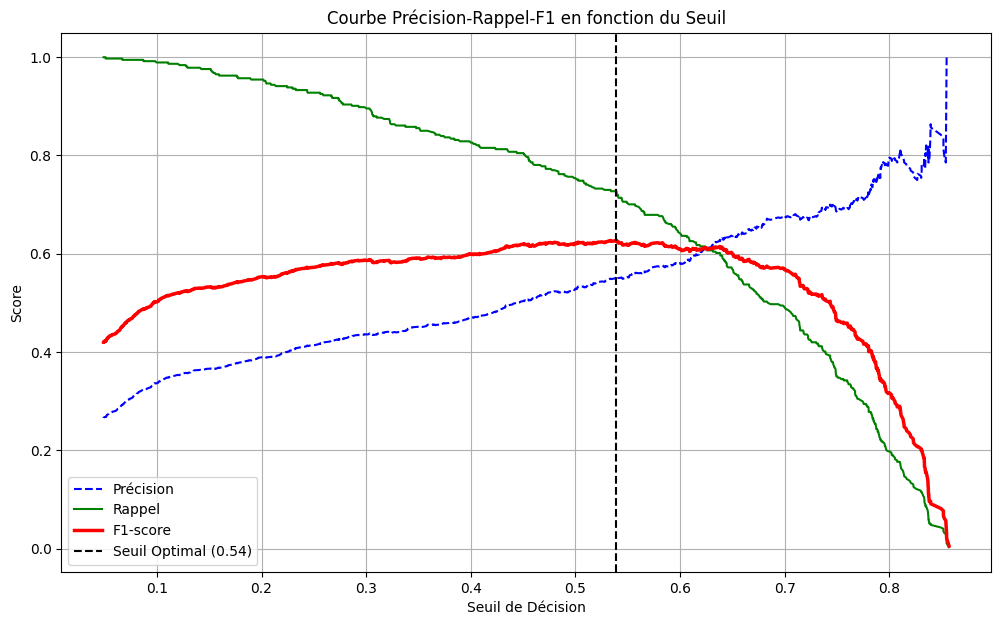

In [18]:
# --- 6. Visualiser la Courbe Précision-Rappel ---

plt.figure(figsize=(12, 7))
plt.plot(thresholds, precisions[:-1], "b--", label="Précision")
plt.plot(thresholds, recalls[:-1], "g-", label="Rappel")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1-score", linewidth=2.5)
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Seuil Optimal ({optimal_threshold:.2f})')
plt.xlabel("Seuil de Décision")
plt.ylabel("Score")
plt.title("Courbe Précision-Rappel-F1 en fonction du Seuil")
plt.legend(loc="best")
plt.grid(True)
plt.show()



--- Performances avec Seuil par Défaut (0.5) ---
Précision : 0.5282
Rappel    : 0.7513
F1-score  : 0.6203

--- Performances avec Seuil Optimisé ---
Précision : 0.5517
Rappel    : 0.7273
F1-score  : 0.6275
Accuracy  : 0.7704

--- Nouvelle Matrice de Confusion (Seuil Optimisé) ---


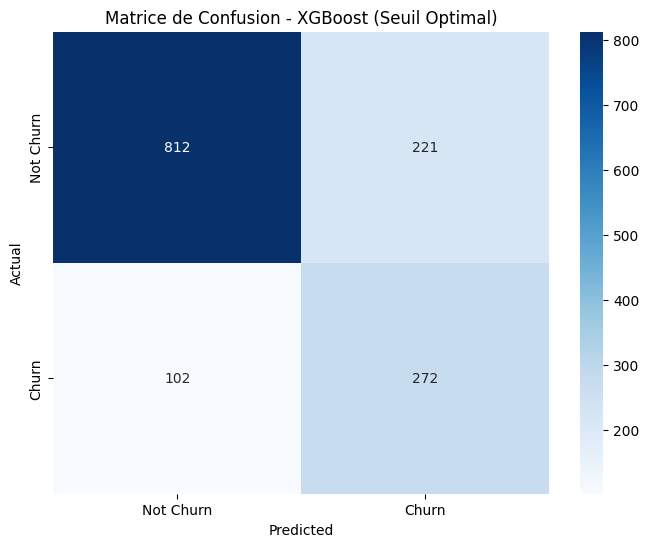

In [19]:




# --- 7. Évaluation Finale avec le Seuil Optimisé ---

# Appliquer le nouveau seuil pour obtenir les prédictions finales
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Calculer les nouvelles métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score

new_accuracy = accuracy_score(y_test, y_pred_optimal)
new_precision = precision_score(y_test, y_pred_optimal)
new_recall = recall_score(y_test, y_pred_optimal)
new_f1 = f1_score(y_test, y_pred_optimal)

print("\n--- Performances avec Seuil par Défaut (0.5) ---")
print(f"Précision : 0.5282")
print(f"Rappel    : 0.7513")
print(f"F1-score  : 0.6203")

print("\n--- Performances avec Seuil Optimisé ---")
print(f"Précision : {new_precision:.4f}")
print(f"Rappel    : {new_recall:.4f}")
print(f"F1-score  : {new_f1:.4f}")
print(f"Accuracy  : {new_accuracy:.4f}")


# Afficher la nouvelle matrice de confusion
print("\n--- Nouvelle Matrice de Confusion (Seuil Optimisé) ---")
cm = confusion_matrix(y_test, y_pred_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Matrice de Confusion - XGBoost (Seuil Optimal)')
plt.show()